**Tripadvisor Hotel Review**

**Libraries**

In [65]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from imblearn import over_sampling
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt 
import matplotlib

**Load data**

In [2]:
data = pd.read_csv("tripadvisor_hotel_reviews.csv")
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


**Missing values**

In [3]:
num_of_missing=data.isnull().sum(axis = 0)

print("number of missing values",num_of_missing.sum())
num_of_duplicated=data[data.duplicated()]
print("number of duplicated rows",num_of_duplicated.shape[0])

number of missing values 0
number of duplicated rows 0


**Mining Opinion from Ratings**

In [4]:
for index,row in data.iterrows():
    if row['Rating']==3:
        data=data.drop(index)
        
    elif row['Rating']>3:#positive comment
        data.loc[index,'Rating']=1
        
    else:#negative comment
        data.loc[index,'Rating']=0

data = data.reset_index(drop=True)
data

,Review,Rating
0,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,0
2,"unique, great stay, wonderful time hotel monac...",1
3,"great stay great stay, went seahawk game aweso...",1
4,love monaco staff husband stayed hotel crazy w...,1
...,...,...
18302,"best kept secret 3rd time staying charm, not 5...",1
18303,great location price view hotel great quick pl...,1
18304,"ok just looks nice modern outside, desk staff ...",0
18305,hotel theft ruined vacation hotel opened sept ...,0


**Checking for Imbalanced Data**

In [5]:
data['Rating'].value_counts(normalize=True) * 100

1    82.443874
0    17.556126
Name: Rating, dtype: float64

**Data cleaning**

In [6]:
import re
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)|(\_)")


def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]

    return reviews


data["Review"] = preprocess_reviews(data["Review"])
#data.head()

**Remove stopwords**

In [7]:
#import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

english_stop_words = stopwords.words('english')
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split()
                      if word not in english_stop_words])
        )
    return removed_stop_words

data["Review"] = remove_stop_words(data["Review"])
data

,Review,Rating
0,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,0
2,unique great stay wonderful time hotel monaco ...,1
3,great stay great stay went seahawk game awesom...,1
4,love monaco staff husband stayed hotel crazy w...,1
...,...,...
18302,best kept secret rd time staying charm star ca...,1
18303,great location price view hotel great quick pl...,1
18304,ok looks nice modern outside desk staff nt par...,0
18305,hotel theft ruined vacation hotel opened sept ...,0


**Normalization to its true root**

In [8]:
import nltk
#nltk.download()
#nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import PorterStemmer
porter=PorterStemmer()
from nltk.stem.wordnet import WordNetLemmatizer

#nltk.download('punkt')
lemmatizer = WordNetLemmatizer()

from nltk.corpus import wordnet
    
    
from nltk.tag.perceptron import PerceptronTagger
tagger = PerceptronTagger()

def stemSentence(sentence):
    stem_sentence=[]
    
    for word, tag in tagger.tag(word_tokenize(sentence)):
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else 'n'
        word=lemmatizer.lemmatize(word,wntag)
        stem_sentence.append(porter.stem(word))
        #stem_sentence.append(" ")
        
    return " ".join(stem_sentence)


for index,row in data.iterrows():
    review = stemSentence(row['Review'])
    data.loc[index,'Review'] = review
    
    
data    

,Review,Rating
0,nice hotel expens park get good deal stay hote...,1
1,ok noth special charg diamond member hilton de...,0
2,uniqu great stay wonder time hotel monaco loca...,1
3,great stay great stay go seahawk game awesom d...,1
4,love monaco staff husband stay hotel crazi wee...,1
...,...,...
18302,best kept secret rd time stay charm star ca nt...,1
18303,great locat price view hotel great quick place...,1
18304,ok look nice modern outsid desk staff nt parti...,0
18305,hotel theft ruin vacat hotel open sept guest w...,0


**Split the data**

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data["Review"], data["Rating"], test_size = 0.3)

**Vectorization binary 3-grams**

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3))

ngram_vectorizer.fit(X_train)
ngram_vectorizer.fit(X_test)
binary_train = ngram_vectorizer.transform(X_train)
binary_test = ngram_vectorizer.transform(X_test)

**Vectorization word-count 3-grams**

In [11]:
ngram_vectorizer = CountVectorizer(binary=False, ngram_range=(1, 3))

ngram_vectorizer.fit(X_train)
ngram_vectorizer.fit(X_test)
count_train = ngram_vectorizer.transform(X_train)
count_test = ngram_vectorizer.transform(X_test)

**Vectorization tf-idf 3-grams**

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,3))

vectorizer.fit(X_train)
vectorizer.fit(X_test)
tf_idf_train = vectorizer.transform(X_train)
tf_idf_test = vectorizer.transform(X_test)

**Handling Imbalanced Data**

In [16]:
rus = RandomOverSampler(random_state=777)

X_train_bin, y_train_bin = rus.fit_sample(binary_train, y_train)

In [17]:
X_train_count, y_train_count = rus.fit_sample(count_train, y_train)

In [18]:
X_train_tf_idf, y_train_tf_idf = rus.fit_sample(tf_idf_train, y_train)

**Modeling**

**Logistic Regression**

In [25]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train_bin, y_train_bin)
pred=lr.predict(binary_test)
acc_lr_binary=metrics.accuracy_score(y_test, pred)
tn, fp, fn, tp = confusion_matrix( y_test, pred).ravel()
PP_lr_bin = tp / (tp + fp)
NP_lr_bin = tn /(tn + fn)
print("Positive precision:",PP_lr_bin)
print("Negative precision:",NP_lr_bin)
print("Accuracy test:",acc_lr_binary)

Positive precision: 0.9695162359178264
Negative precision: 0.8913043478260869
Accuracy test: 0.9557618787547788


In [27]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train_count, y_train_count)
pred=lr.predict(count_test)
acc_lr_count=metrics.accuracy_score(y_test, pred)
tn, fp, fn, tp = confusion_matrix( y_test, pred).ravel()
PP_lr_count = tp / (tp + fp)
NP_lr_count = tn /(tn + fn)
print("Positive precision:",PP_lr_count)
print("Negative precision:",NP_lr_count)
print("Accuracy test:",acc_lr_count)

Positive precision: 0.9684605205116894
Negative precision: 0.8925964546402503
Accuracy test: 0.955215729109776


In [28]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train_tf_idf, y_train_tf_idf)
pred=lr.predict(tf_idf_test)
acc_lr_tf_idf=metrics.accuracy_score(y_test, pred)
tn, fp, fn, tp = confusion_matrix( y_test, pred).ravel()
PP_lr_tf_idf = tp / (tp + fp)
NP_lr_tf_idf = tn /(tn + fn)
print("Positive precision:",PP_lr_tf_idf)
print("Negative precision:",NP_lr_tf_idf)
print("Accuracy test:",acc_lr_tf_idf)

Positive precision: 0.9703277236492471
Negative precision: 0.8853633572159673
Accuracy test: 0.955215729109776


**SVM**

binary 3-grams

In [ ]:
accuracy = []
regularization = [0.01, 0.05, 0.25, 0.5, 1]
for c in regularization:
    svc = LinearSVC(C=c)
    svc.fit(X_train_bin, y_train_bin)
    accuracy.append(accuracy_score(y_test, svc.predict(binary_test)))
    print("Accuracy for C=%s: %s"
          % (c, accuracy_score(y_test, svc.predict(binary_test))))

In [30]:
#so we choose c = 0.01
svc = LinearSVC(C=0.01)
svc.fit(X_train_bin, y_train_bin)
pred=svc.predict(binary_test)
acc_svc_binary=metrics.accuracy_score(y_test, pred)
tn, fp, fn, tp = confusion_matrix( y_test, pred).ravel()
PP_svc_bin = tp / (tp + fp)
NP_svc_bin = tn /(tn + fn)
print("Positive precision:",PP_svc_bin)
print("Negative precision:",NP_svc_bin)
print("Accuracy test:",acc_svc_binary)

Positive precision: 0.9686741672181778
Negative precision: 0.8927083333333333
Accuracy test: 0.9553977789914436


word-count 3-grams

In [ ]:
accuracy = []
regularization = [0.01, 0.05, 0.25, 0.5, 1]
for c in regularization:
    svc = LinearSVC(C=c)
    svc.fit(X_train_count, y_train_count)
    accuracy.append(accuracy_score(y_test, svc.predict(count_test)))
    print("Accuracy for C=%s: %s"
          % (c, accuracy_score(y_test, svc.predict(count_test))))

In [31]:
#so we choose c = 0.01
svc = LinearSVC(C=0.01)
svc.fit(X_train_count, y_train_count)
pred=svc.predict(count_test)
acc_svc_count=metrics.accuracy_score(y_test, pred)
tn, fp, fn, tp = confusion_matrix( y_test, pred).ravel()
PP_svc_count = tp / (tp + fp)
NP_svc_count = tn /(tn + fn)
print("Positive precision:",PP_svc_count)
print("Negative precision:",NP_svc_count)
print("Accuracy test:",acc_svc_count)

Positive precision: 0.9676068752754517
Negative precision: 0.8921465968586387
Accuracy test: 0.9544875295831058


tf-idf 3grams

In [ ]:
accuracy = []
regularization = [0.01, 0.05, 0.25, 0.5, 1]
for c in regularization:
    svc = LinearSVC(C=c)
    svc.fit(X_train_tf_idf, y_train_tf_idf)
    accuracy.append(accuracy_score(y_test, svc.predict(tf_idf_test)))
    print("Accuracy for C=%s: %s"
          % (c, accuracy_score(y_test, svc.predict(tf_idf_test))))

In [32]:
#so we choose c = 0.05
svc = LinearSVC(C=0.05)
svc.fit(X_train_tf_idf, y_train_tf_idf)
pred=svc.predict(tf_idf_test)
acc_svc_tf_idf=metrics.accuracy_score(y_test, pred)
tn, fp, fn, tp = confusion_matrix( y_test, pred).ravel()
PP_svc_tf_idf = tp / (tp + fp)
NP_svc_tf_idf = tn /(tn + fn)
print("Positive precision:",PP_svc_tf_idf)
print("Negative precision:",NP_svc_tf_idf)
print("Accuracy test:",acc_svc_tf_idf)

Positive precision: 0.9717275155832591
Negative precision: 0.8711288711288712
Accuracy test: 0.9533952302931004


**Naive-Bayes**

binary 3-grams

In [33]:
nb = MultinomialNB()
nb.fit(X_train_bin, y_train_bin)
pred = nb.predict(binary_test)
acc_nb_bin = metrics.accuracy_score(y_test, pred)
tn, fp, fn, tp = confusion_matrix( y_test, pred).ravel()
PP_nb_bin = tp / (tp + fp)
NP_nb_bin = tn /(tn + fn)
print("Positive precision:",PP_nb_bin)
print("Negative precision:",NP_nb_bin)
print("Accuracy score:" , acc_nb_bin)

Positive precision: 0.9524523452559435
Negative precision: 0.9429611650485437
Accuracy score: 0.9510285818314218


word-count 3-grams

In [34]:
nb = MultinomialNB()
nb.fit(X_train_count, y_train_count)
pred = nb.predict(count_test)
acc_nb_count = metrics.accuracy_score(y_test, pred)
tn, fp, fn, tp = confusion_matrix( y_test, pred).ravel()
PP_nb_count = tp / (tp + fp)
NP_nb_count = tn /(tn + fn)
print("Positive precision:",PP_nb_count)
print("Negative precision:",NP_nb_count)
print("Accuracy score:" , acc_nb_count)

Positive precision: 0.9504802561366061
Negative precision: 0.9492574257425742
Accuracy score: 0.9503003823047516


In [35]:
nb = MultinomialNB()
nb.fit(X_train_tf_idf, y_train_tf_idf)
pred = nb.predict(tf_idf_test)
acc_nb_tf_idf = metrics.accuracy_score(y_test, pred)
tn, fp, fn, tp = confusion_matrix( y_test, pred).ravel()
PP_nb_tf_idf = tp / (tp + fp)
NP_nb_tf_idf = tn /(tn + fn)
print("Positive precision:",PP_nb_tf_idf)
print("Negative precision:",NP_nb_tf_idf)
print("Accuracy score:" , acc_nb_tf_idf)

Positive precision: 0.9826631350830725
Negative precision: 0.6917910447761194
Accuracy score: 0.9117058073912252


**Random Forest Classifier**

binary 3-grams

In [36]:
rf = RandomForestClassifier(max_depth = 10)
rf.fit(X_train_bin, y_train_bin)
pred = rf.predict(binary_test)
acc_rf_bin = metrics.accuracy_score(y_test, pred)
tn, fp, fn, tp = confusion_matrix( y_test, pred).ravel()
PP_rf_bin = tp / (tp + fp)
NP_rf_bin = tn /(tn + fn)
print("Positive precision:",PP_rf_bin)
print("Negative precision:",NP_rf_bin)
print("Accuracy score:" , acc_rf_bin)

Positive precision: 0.9455594002306805
Negative precision: 0.6588946459412781
Accuracy score: 0.885126524667759


word-count 3-grams

In [37]:
rf = RandomForestClassifier(max_depth = 10)
rf.fit(X_train_count , y_train_count)
pred = rf.predict(count_test)
acc_rf_count = metrics.accuracy_score(y_test, pred)
tn, fp, fn, tp = confusion_matrix( y_test, pred).ravel()
PP_rf_count = tp / (tp + fp)
NP_rf_count = tn /(tn + fn)
print("Positive precision:",PP_rf_count)
print("Negative precision:",NP_rf_count)
print("Accuracy score:" , acc_rf_count)

Positive precision: 0.9530323757409941
Negative precision: 0.7163504968383018
Accuracy score: 0.90533406153286


tf-idf 3grams

In [40]:
rf = RandomForestClassifier(max_depth = 10)
rf.fit(X_train_tf_idf, y_train_tf_idf)
pred = rf.predict(tf_idf_test)
acc_rf_tf_idf = metrics.accuracy_score(y_test, pred)
tn, fp, fn, tp = confusion_matrix( y_test, pred).ravel()
PP_rf_tf_idf = tp / (tp + fp)
NP_rf_tf_idf = tn /(tn + fn)
print("Positive precision:",PP_rf_tf_idf)
print("Negative precision:",NP_rf_tf_idf)
print("Accuracy score:" , acc_rf_tf_idf)

Positive precision: 0.964993564993565
Negative precision: 0.5366915422885572
Accuracy score: 0.8396140542508648


**Boosting**

binary 3-grams

In [41]:
boosting = GradientBoostingClassifier(n_estimators=50,max_depth = 5)
boosting.fit(X_train_bin, y_train_bin)
pred = boosting.predict(binary_test)
acc_boosting_bin = metrics.accuracy_score(y_test, pred)
tn, fp, fn, tp = confusion_matrix( y_test, pred).ravel()
PP_boosting_bin = tp / (tp + fp)
NP_boosting_bin = tn /(tn + fn)
print("Positive precision:",PP_boosting_bin)
print("Negative precision:",NP_boosting_bin)
print("Accuracy score:" , acc_boosting_bin)

Positive precision: 0.9576968272620446
Negative precision: 0.6615508885298869
Accuracy score: 0.8909521208811214


word-count 3-grams

In [42]:
boosting = GradientBoostingClassifier(n_estimators=50,max_depth = 5)
boosting.fit(X_train_count, y_train_count)
pred = boosting.predict(count_test)
acc_boosting_count = metrics.accuracy_score(y_test, pred)
tn, fp, fn, tp = confusion_matrix( y_test, pred).ravel()
PP_boosting_count = tp / (tp + fp)
NP_boosting_count = tn /(tn + fn)
print("Positive precision:",PP_boosting_count)
print("Negative precision:",NP_boosting_count)
print("Accuracy score:" , acc_boosting_count)

Positive precision: 0.9587555974546311
Negative precision: 0.6592
Accuracy score: 0.8905880211177862


tf-idf 3grams

In [43]:
boosting = GradientBoostingClassifier(n_estimators=50,max_depth = 5)
boosting.fit(X_train_tf_idf, y_train_tf_idf)
pred = boosting.predict(tf_idf_test)
acc_boosting_tf_idf = metrics.accuracy_score(y_test, pred)
tn, fp, fn, tp = confusion_matrix( y_test, pred).ravel()
PP_boosting_tf_idf = tp / (tp + fp)
NP_boosting_tf_idf = tn /(tn + fn)
print("Positive precision:",PP_boosting_tf_idf)
print("Negative precision:",NP_boosting_tf_idf)
print("Accuracy score:" , acc_boosting_tf_idf)

Positive precision: 0.9735294117647059
Negative precision: 0.513405590416429
Accuracy score: 0.8266885126524668


**MLP**

In [45]:
from sklearn.neural_network import MLPClassifier

binary 3-grams

In [50]:
final_model = MLPClassifier(hidden_layer_sizes=(30,20,10), activation='logistic',max_iter=5, early_stopping=True,verbose=True)
final_model.fit(X_train_bin, y_train_bin)
y_pred = final_model.predict(binary_test)
tn, fp, fn, tp = confusion_matrix( y_test, y_pred).ravel()
PP_MLP_bin = tp / (tp + fp)
NP_MLP_bin = tn /(tn + fn)
acc_mlp_bin = accuracy_score(y_test, y_pred)
print("Positive precision:",PP_MLP_bin)
print("Negative precision:",NP_MLP_bin)
print("Final Accuracy:", acc_mlp_bin)

Iteration 1, loss = 0.67230554
Validation score: 0.964151
Iteration 2, loss = 0.43595161
Validation score: 0.986792
Iteration 3, loss = 0.21361819
Validation score: 0.992453
Iteration 4, loss = 0.13229972
Validation score: 0.992453
Iteration 5, loss = 0.09418054
Validation score: 0.991038


C:\Users\panag\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


Positive precision: 0.9536027367970922
Negative precision: 0.9583333333333334
Final Accuracy: 0.9543054797014382


word-count 3-grams

In [51]:
final_model = MLPClassifier(hidden_layer_sizes=(30,20,10), activation='logistic',max_iter=5, early_stopping=True,verbose=True)
final_model.fit(X_train_count, y_train_count)
y_pred = final_model.predict(count_test)
tn, fp, fn, tp = confusion_matrix( y_test, y_pred).ravel()
PP_MLP_count = tp / (tp + fp)
NP_MLP_count = tn /(tn + fn)
acc_mlp_count = accuracy_score(y_test, y_pred)
print("Positive precision:",PP_MLP_count)
print("Negative precision:",NP_MLP_count)
print("Final Accuracy:", acc_mlp_count)

Iteration 1, loss = 0.63414958
Validation score: 0.964151
Iteration 2, loss = 0.31498245
Validation score: 0.987264
Iteration 3, loss = 0.14326507
Validation score: 0.993868
Iteration 4, loss = 0.08688754
Validation score: 0.991509
Iteration 5, loss = 0.06130748
Validation score: 0.992453
Positive precision: 0.952604611443211
Negative precision: 0.9604449938195303
Final Accuracy: 0.9537593300564354


C:\Users\panag\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


tf-idf 3grams

In [53]:
final_model = MLPClassifier(hidden_layer_sizes=(30,20,10), activation='logistic',max_iter=5, early_stopping=True,verbose=True)
final_model.fit(X_train_tf_idf, y_train_tf_idf)
y_pred = final_model.predict(tf_idf_test)
tn, fp, fn, tp = confusion_matrix( y_test, y_pred).ravel()
PP_MLP_tf_idf = tp / (tp + fp)
NP_MLP_tf_idf = tn /(tn + fn)
acc_mlp_tf_idf = accuracy_score(y_test, y_pred)
print("Positive precision:",PP_MLP_tf_idf)
print("Negative precision:",NP_MLP_tf_idf)
print("Final Accuracy:", acc_mlp_tf_idf)

Iteration 1, loss = 0.69281863
Validation score: 0.922642
Iteration 2, loss = 0.68344464
Validation score: 0.858962
Iteration 3, loss = 0.51336001
Validation score: 0.972170
Iteration 4, loss = 0.22243866
Validation score: 0.989151
Iteration 5, loss = 0.12007973
Validation score: 0.991038


C:\Users\panag\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


Positive precision: 0.9481402763018066
Negative precision: 0.9581218274111675
Final Accuracy: 0.9495721827780812


**Plots**

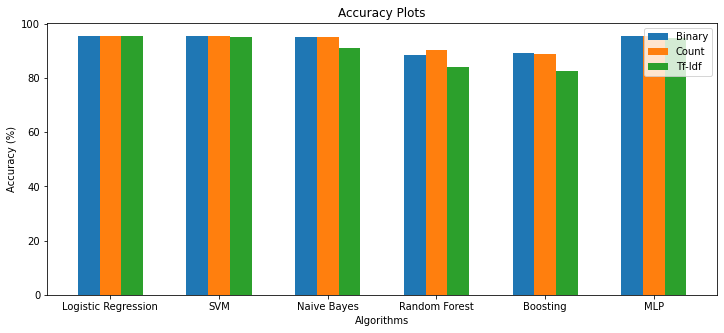

In [75]:
X = ['Logistic Regression','SVM','Naive Bayes','Random Forest','Boosting','MLP']
Accuracy_bin = [acc_lr_binary*100,acc_svc_binary*100,acc_nb_bin*100,acc_rf_bin*100,acc_boosting_bin*100,acc_mlp_bin*100]
Accuracy_count = [acc_lr_count*100,acc_svc_count*100,acc_nb_count*100,acc_rf_count*100,acc_boosting_count*100,acc_mlp_count*100]
Accuracy_tf_idf = [acc_lr_tf_idf*100,acc_svc_tf_idf*100,acc_nb_tf_idf*100,acc_rf_tf_idf*100,acc_boosting_tf_idf*100,acc_mlp_tf_idf*100]

X_axis = np.arange(len(X))
  
plt.figure(figsize=(12,5))

plt.bar(X_axis - 0.2, Accuracy_bin, 0.2 , label = 'Binary')
plt.bar(X_axis , Accuracy_count, 0.2 , label = 'Count')
plt.bar(X_axis + 0.2 , Accuracy_tf_idf, 0.2 , label = 'Tf-Idf')

plt.xticks(X_axis, X)
plt.xlabel("Algorithms")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Plots")
plt.legend()
plt.show()

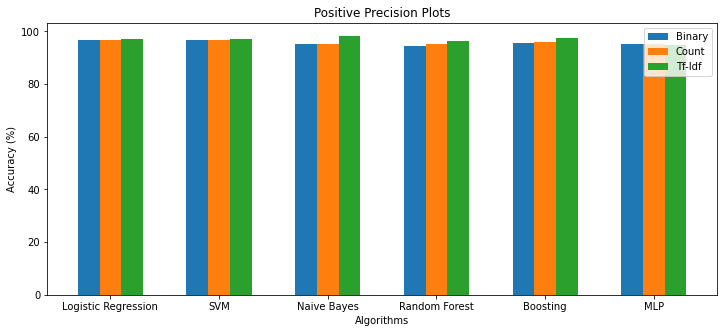

In [77]:
X = ['Logistic Regression','SVM','Naive Bayes','Random Forest','Boosting','MLP']
PP_bin = [PP_lr_bin*100,PP_svc_bin*100,PP_nb_bin*100,PP_rf_bin*100,PP_boosting_bin*100,PP_MLP_bin*100]
PP_count = [PP_lr_count*100,PP_svc_count*100,PP_nb_count*100,PP_rf_count*100,PP_boosting_count*100,PP_MLP_count*100]
PP_tf_idf = [PP_lr_tf_idf*100,PP_svc_tf_idf*100,PP_nb_tf_idf*100,PP_rf_tf_idf*100,PP_boosting_tf_idf*100,PP_MLP_tf_idf*100]

X_axis = np.arange(len(X))
  
plt.figure(figsize=(12,5))

plt.bar(X_axis - 0.2, PP_bin, 0.2 , label = 'Binary')
plt.bar(X_axis , PP_count, 0.2 , label = 'Count')
plt.bar(X_axis + 0.2 , PP_tf_idf, 0.2 , label = 'Tf-Idf')

plt.xticks(X_axis, X)
plt.xlabel("Algorithms")
plt.ylabel("Accuracy (%)")
plt.title("Positive Precision Plots")
plt.legend()
plt.show()

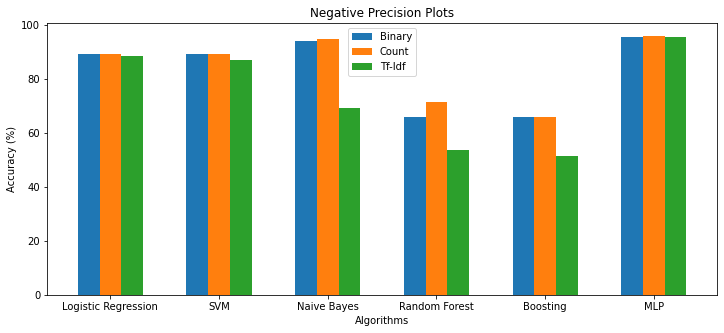

In [78]:
X = ['Logistic Regression','SVM','Naive Bayes','Random Forest','Boosting','MLP']
NP_bin = [NP_lr_bin*100,NP_svc_bin*100,NP_nb_bin*100,NP_rf_bin*100,NP_boosting_bin*100,NP_MLP_bin*100]
NP_count = [NP_lr_count*100,NP_svc_count*100,NP_nb_count*100,NP_rf_count*100,NP_boosting_count*100,NP_MLP_count*100]
NP_tf_idf = [NP_lr_tf_idf*100,NP_svc_tf_idf*100,NP_nb_tf_idf*100,NP_rf_tf_idf*100,NP_boosting_tf_idf*100,NP_MLP_tf_idf*100]

X_axis = np.arange(len(X))
  
plt.figure(figsize=(12,5))

plt.bar(X_axis - 0.2, NP_bin, 0.2 , label = 'Binary')
plt.bar(X_axis , NP_count, 0.2 , label = 'Count')
plt.bar(X_axis + 0.2 , NP_tf_idf, 0.2 , label = 'Tf-Idf')

plt.xticks(X_axis, X)
plt.xlabel("Algorithms")
plt.ylabel("Accuracy (%)")
plt.title("Negative Precision Plots")
plt.legend()
plt.show()